In [1]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings("ignore")

import os, sys, glob
import json
import re
import numpy as np
import pandas as pd
from natsort import natsorted

import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats
from scipy.stats import pearsonr, spearmanr, kendalltau
import matplotlib.colors as clr

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multitest import multipletests

sys.path.append('/dartfs/rc/lab/F/FinnLab/tommy/isc_asynchrony_behavior/code/utils/')

from config import *
# import nlp_utils as nlp
from dataset_utils import attempt_makedirs
from tommy_utils import nlp
# from preproc_utils import load_model_results, divide_nwp_dataframe
import plotting_utils as utils
import analysis_utils as analysis

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /dartfs/rc/lab/F/FinnLab/tommy/models/token
Login successful


2025-04-09 00:08:59.772418: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-09 00:08:59.772476: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-09 00:08:59.773681: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-09 00:08:59.972495: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-09 00:09:07.830911: W tensorflow/compiler/

In [2]:
# EXPERIMENT_NAME = 'next-word-prediction'
# EXPERIMENT_VERSION = 'pilot-multimodal-01'
task_list = ['black', 'wheretheressmoke', 'howtodraw']
# TASK = 'black'

gentle_dir = os.path.join(BASE_DIR, 'stimuli/gentle')
results_dir = os.path.join(BASE_DIR, 'derivatives/results/behavioral/')
preproc_dir = os.path.join(BASE_DIR, 'stimuli/preprocessed')
prosody_dir = os.path.join(BASE_DIR, 'stimuli/prosody')

# set the directories we need
models_dir = os.path.join(BASE_DIR, 'derivatives/model-predictions')

word_model_name = 'fasttext'

### Test results analysis

In [4]:
MLM_MODELS = list(nlp.MLM_MODELS_DICT.keys())[1:]
CLM_MODELS = list(nlp.CLM_MODELS_DICT.keys()) 
model_names = CLM_MODELS + MLM_MODELS

# Grab the quadrants across tasks
df_quadrants = utils.load_task_model_quadrants(preproc_dir, models_dir, task_list, model_names, 'fasttext')

# Get the average model difference across tasks
df_task_results = pd.read_csv(os.path.join(results_dir, f'all-task_group-analyzed-behavior_window-size-25_human-model-distributions-lemmatized.csv'))

model_names = df_task_results['model_name'].unique()
quadrant_columns = ['fasttext_avg_accuracy', 'entropy', 'word_index', 'entropy_group', 'accuracy_group']
# model_names = ['gpt2-xl']

# Grab the quadrants across tasks
df_quadrants = utils.load_task_model_quadrants(preproc_dir, models_dir, task_list, model_names, 'fasttext')

### Functions to create custom density map

### Create custom density map

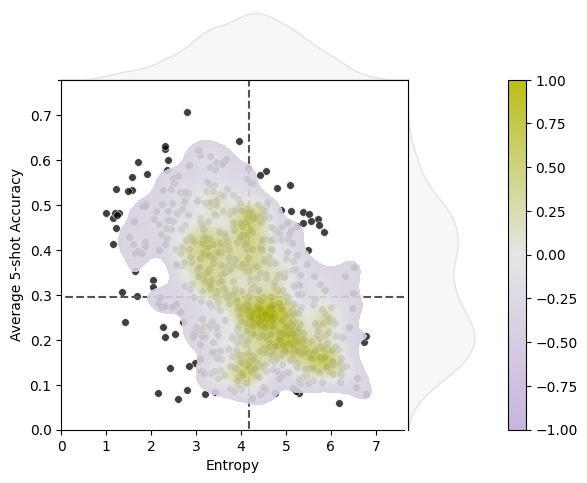

In [22]:
cmap = clr.LinearSegmentedColormap.from_list('human-model', ['#B2B800', '#E3E3E3', '#C2ADDA'], N=256).reversed()

g = utils.create_joint_density_plot(df_task_results, df_quadrants, cmap=cmap)

## Load data across different window sizes

In [37]:
window_sizes = [
    2, 3, 4, 5, 10, 25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300
]

df_stack = []

for task in task_list:
    for i, window in enumerate(window_sizes):
        fn = os.path.join(results_dir, f'task-{task}_group-analyzed-behavior_window-size-{str(window).zfill(5)}_human-model-lemmatized.csv')
        df = pd.read_csv(fn)
        df['task'] = task
        df['window_size'] = window
        df['window_number'] = i
        df_stack.append(df.copy())

df_stack = pd.concat(df_stack).reset_index(drop=True)


# # Convert the column to a Categorical type with the custom order, sort the dataframe by this categorical column
# df_subject_accuracy['modality'] = pd.Categorical(df_subject_accuracy['modality'], categories=p.modality_list, ordered=True)
# df_subject_accuracy = df_subject_accuracy.sort_values('modality') 

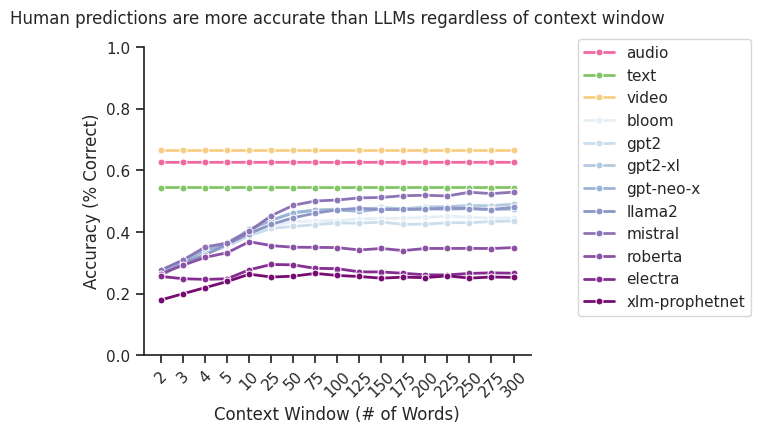

In [61]:
cmap = utils.create_colormap(dtype='multimodal', continuous=False)

# df_stack = df_stack[df_stack['window_size'] >= 10]
sns.set(style='ticks', rc={'figure.figsize': (5, 4)})

sns.lineplot(df_stack, x='window_number', y='fasttext_top_word_accuracy', hue='modality', marker="o", markersize=5, ci=None, palette=cmap, linewidth=2)

plt.gca().legend(bbox_to_anchor=(1.1, 1.05))
plt.xlabel('Context Window (# of Words)')
plt.ylabel('Accuracy (% Correct)')
plt.ylim([0, 1.0])

# Ensure y-ticks are visible
# Set x-ticks to be evenly spaced with window sizes as labels
# plt.xticks(window_sizes)
plt.xticks(range(len(window_sizes)), window_sizes, rotation=45)

# plt.hlines(0, -50, 350, colors='k')
# plt.xlim([-15, 310])

plt.title('Human predictions are more accurate than LLMs regardless of context window', y=1.05)

sns.despine()
# plt.ylim([0, 0.7])

### Double check with raw data

In [44]:
EXPERIMENT_NAME = 'next-word-prediction'
experiment_version = 'final-multimodal-01'
task = 'wheretheressmoke'
modality_list = ['video', 'audio', 'text']

N_ORDERS = {
    'black': 4,
    'wheretheressmoke': 3,
    'howtodraw': 3
}


# Sourced for aggregating data across subjects
results_dir = os.path.join(BASE_DIR, 'experiments',  EXPERIMENT_NAME, 'results', experiment_version)
preproc_dir = os.path.join(BASE_DIR, 'stimuli/preprocessed')
audio_dir = os.path.join(BASE_DIR, 'stimuli/cut_audio/', experiment_version)
behavioral_dir = os.path.join(BASE_DIR, 'derivatives/results/behavioral/') # where we will write our data

# attempt_makedirs(behavioral_dir)

###############################################
####### Load transcript with prosody info #####
###############################################

# Load transcript --> use the version that we include prosody values within
df_transcript = pd.read_csv(os.path.join(preproc_dir, task, f'{task}_transcript-selected_prosody.csv'))
df_transcript = df_transcript.rename(columns={'Word_Written': 'word', 'Punctuation': 'punctuation'})

prosody_columns = [
    'prominence', 'prominence_mean', 'prominence_std', 
    'relative_prominence', 'relative_prominence_norm',
    'boundary', 'boundary_mean', 'boundary_std', 
]

########################################################
#### Aggregate results across audio/text modalities ####
########################################################

df_aggregated_results = []

for modality in modality_list:

    # Process data for modality
    df_modality = analysis.aggregate_participant_responses(results_dir, audio_dir, task=task, modality=modality, n_orders=N_ORDERS[task])
    df_modality = analysis.calculate_response_accuracy(df_modality)

    # Add in prosody columns and add to the list
    df_modality.loc[:, prosody_columns] = df_transcript.loc[df_modality['word_index'], prosody_columns].reset_index(drop=True)
    df_aggregated_results.append(df_modality)

# Concatenate and save compiled cleaned
df_aggregated_results = pd.concat(df_aggregated_results).reset_index(drop=True)

Aggregating wheretheressmoke - video
Total of 149 subjects


100%|██████████| 149/149 [01:14<00:00,  2.00it/s]


Aggregating wheretheressmoke - audio
Total of 150 subjects


100%|██████████| 150/150 [01:17<00:00,  1.93it/s]


Aggregating wheretheressmoke - text
Total of 150 subjects


100%|██████████| 150/150 [01:15<00:00,  1.99it/s]


In [45]:
df_aggregated_results = analysis.calculate_response_accuracy(df_aggregated_results)

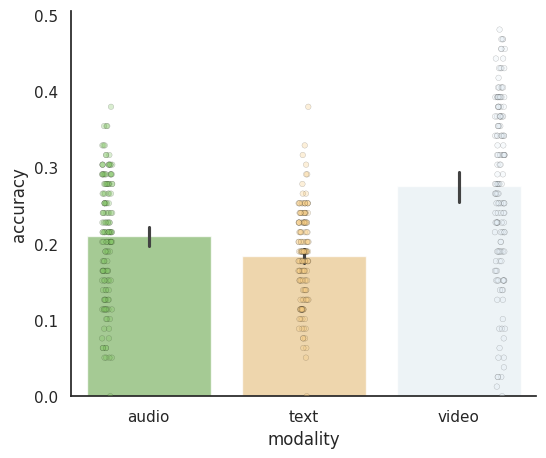

In [47]:
accuracy = df_aggregated_results.groupby(['modality', 'subject'])['accuracy'].mean().reset_index()

cmap = utils.create_colormap(continuous=False)
ax = utils.plot_bar_results(accuracy, x='modality', y='accuracy', hue='modality', cmap=cmap)

### Test three bars

In [1]:
import os, sys
import argparse
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

sys.path.append('../utils/')

from config import *
from dataset_utils import attempt_makedirs
import plotting_utils as utils

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /dartfs/rc/lab/F/FinnLab/tommy/models/token
Login successful


2025-02-21 08:28:47.838903: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-21 08:28:47.838964: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-21 08:28:47.839022: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-21 08:28:47.851940: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-21 08:29:12.145156: W tensorflow/compiler/

In [73]:
task_list = ['black', 'wheretheressmoke', 'howtodraw']

results_dir = os.path.join(BASE_DIR, 'derivatives/results/behavioral/')
plots_dir = os.path.join(BASE_DIR, 'derivatives/plots/final/behavioral/')

df_stack = []

for task in task_list:
    df_task = pd.read_csv(os.path.join(results_dir, f'task-{task}_group-cleaned-behavior_lemmatized.csv'))
    df_task['task'] = task
    df_stack.append(df_task)

df_stack = pd.concat(df_stack).reset_index(drop=True)

In [74]:
accuracy = df_stack.groupby(['task', 'modality', 'subject'])['accuracy'].mean().reset_index()

# Define the custom order you want: video, audio, text
order = ['video', 'audio', 'text']

# Convert the column to a Categorical type with the custom order
accuracy['modality'] = pd.Categorical(accuracy['modality'], categories=order, ordered=True)

# Now sort the dataframe by this categorical column
accuracy = accuracy.sort_values('modality')



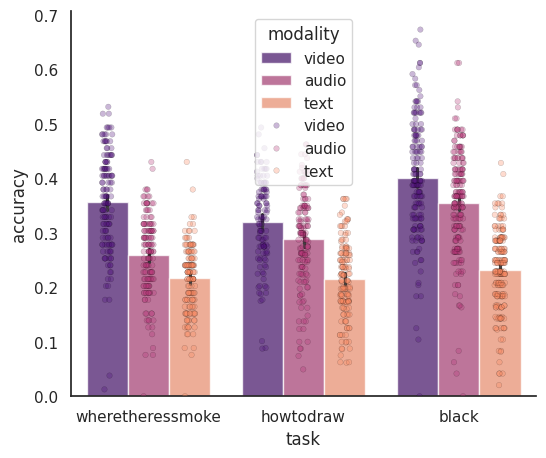

In [78]:
cmap = utils.create_colormap(continuous=False)
ax = utils.plot_bar_results(accuracy, x='task', y='accuracy', hue='modality', hue_order=['video', 'audio', 'text'], cmap='magma')
